In [1]:
from __future__ import division, print_function, unicode_literals
import pymongo
from pandas.io.json import json_normalize
import pandas as pd
import gridfs

db_name = 'binding_via_rc'
client = pymongo.MongoClient()

runs = client[db_name].random_search.runs
fs = gridfs.GridFS(client[db_name], collection='random_search')

In [2]:
from IPython.display  import HTML
# Pretty Pandas Dataframes
HTML("""<style>
    .dataframe * {border-color: #c0c0c0 !important;}
    .dataframe th{background: #eee;}
    .dataframe td{
        background: #fff;
        text-align: right; 
        min-width:5em;
    }
</style>""")

In [3]:
def convert_json_to_nice_dataframe(json_doc):
    # convert the json representation into a pandas table
    dataframe = json_normalize(json_doc)
    # set the experiment id as the index
    dataframe.set_index('_id', inplace=True, drop=True)
    # sort the columns first by nesting depth and then lexicographically
    result = dataframe.reindex_axis(sorted(dataframe.columns, key=lambda x: (len(x.split('.')), x)), axis=1)

    # Convert the column names into a hierarchical multiindex
    def remove_prefix(s, prefix):
        if s.startswith(prefix):
            return s[len(prefix):]
        else:
            return s
        
    def pad_tuples(t, length):
        if len(t) == length:
            return t
        elif len(t) < length:
            return t + ('',) * (length - len(t))
        else:
            raise ValueError('length should not be smaller than tuple length')
    colnames = [tuple(remove_prefix(c, 'config.').split('.')) for c in result.columns]
    maxlen = max([len(c) for c in colnames])
    pad_colnames = [pad_tuples(c, maxlen) for c in colnames]
    result.columns = pd.MultiIndex.from_tuples(pad_colnames)    
    return result
    
    
def get_results(collection, filter_by={}, project=None, sort='result', sort_direction=pymongo.DESCENDING):
    # Set up a project dictionary that ensures the id and result are being returned alongside
    # whatever the user specifies
    project_dict = {'result': True, '_id': True}
    if project is None:
        project_dict['config'] = True
    elif isinstance(project, dict):
        for k, v in project.items():
            project_dict[k] = v
    else:
        for k in project:
            project_dict[k] = True
    
    # get the results from the database
    cursor = collection.find(filter_by, project_dict).sort(sort, sort_direction)
    return convert_json_to_nice_dataframe(cursor)
    

In [4]:
project = {'config.dataset.salt_n_pepper',
           'config.training.learning_rate',
           'config.network_spec',
           'info.best_val_loss',
           'seed'}

# Random Search

## Bars

In [5]:
get_results(runs, {'config.dataset.name': 'bars'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569b2241cf31631e73f716e8,0.951809,Fr100,6.396188,0.0,0.768015
569b1f76cf31630a9a19bedc,0.944172,Ft500,7.992204,0.0,0.252907
569b1d69cf3163f937773d3b,0.940276,Fr1000,7.060688,0.1,0.240011
569b1f79cf31630abcc84869,0.939543,Ft500,8.714043,0.1,0.205109
569b2144cf31631778461244,0.935586,Ft250,9.111683,0.1,0.307353
569b2074cf316311a4ee96e7,0.930049,Ft100,8.917188,0.0,0.177134
569b21accf31631a511aba57,0.923038,Fr1000,7.875782,0.2,0.781158
569b222ccf31631de9f9f198,0.918513,Ft250,13.875007,0.1,0.042981


## Corners

In [6]:
get_results(runs, {'config.dataset.name': 'corners'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569af84ccf316305b38c2240,0.853866,Fr100,6.305510,0.0,0.001920
569aef94cf3163c813473b57,0.843495,Fr500,5.869690,0.2,0.096659
569ae631cf316389c5f037ef,0.838245,Fs250,13.376644,0.3,0.323203
569aea8bcf3163a6e6ee9f99,0.832625,Fr500,1.451425,0.0,0.006335
569aed85cf3163ba4d7f634a,0.831904,Fs250,9.999545,0.2,0.099859
569ae6f0cf31638ea4c2f238,0.831557,Fr500,2.452440,0.1,0.050331
569aea44cf3163a49edb08c2,0.831298,Ft250,7.028824,0.0,0.003493
569aefcecf3163c99b0445a1,0.831253,Ft100,12.066634,0.1,0.025796


## Simple Superposition

In [7]:
get_results(runs, {'config.dataset.name': 'simple_superpos'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569aba19cf316364cd7fc539,0.890472,Fr100,20.599499,0.1,0.366627
569abad4cf31636a6cb02519,0.887573,Ft250,18.875254,0.0,0.202330
569ab8b2cf31635a620b18e2,0.873740,Fr500,19.105598,0.1,0.230945
569ab821cf31635638b868cd,0.859262,Fr250,18.926611,0.0,0.024318
569ab981cf3163607104f20e,0.846790,Ft1000,19.121475,0.1,0.203595
569ab8fbcf31635c89c8b64c,0.832296,Ft250,19.946453,0.0,0.254829
569ab813cf316355d67db1dc,0.813838,Ft100,19.401131,0.0,0.463935
569aba11cf3163649bf3ff14,0.812445,Ft100,21.208118,0.2,0.344165


## MNIST + Shape

In [8]:
get_results(runs, {'config.dataset.name': 'mnist_shape'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569acf56cf3163f0c2b6085a,0.545559,Fs250,106.287130,0.6,0.031685
569adaa1cf31633e4272af0d,0.533948,Fr100,102.550669,0.6,0.009396
569ac296cf31639d1f98b0d1,0.533539,Ft500,72.088469,0.4,0.002125
569adcb1cf31634bb7335da0,0.522434,Ft500,79.410544,0.5,0.009717
569ad3c3cf3163113561f489,0.513365,Ft250,73.749879,0.4,0.077672
569ad764cf3163290b9c1ad2,0.488827,Ft500,59.769147,0.4,0.051148
569ade4ecf3163564a51c7d7,0.484540,Fs250,137.159631,0.7,0.009617
569adb9ccf316344a92e5360,0.482411,Ft500,134.949902,0.7,0.002395


## Multi MNIST

In [9]:
get_results(runs, {'config.dataset.name': 'multi_mnist'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569a768acf3163a4f6cab136,0.651657,Fr1000,155.669419,0.6,0.011362
569a768ccf3163a5793822ed,0.640621,Fr1000,280.214038,0.8,0.007326
569a7689cf3163a4e062e4db,0.636436,Fr1000,208.643726,0.7,0.002983
569a768acf3163a5297ff50b,0.628498,Fs500,285.104148,0.8,0.003513
569a768acf3163a53b7ffc76,0.623743,Fr250,214.903886,0.7,0.002265
569a8d29cf31633c488c2d4e,0.623051,Fs250,170.689554,0.5,0.001022
569a768dcf3163a57c7655a9,0.619074,Fs250,231.957337,0.7,0.008483
569a768acf3163a505c59933,0.616807,Fr500,195.070702,0.5,0.018234


## Shapes

In [10]:
get_results(runs, {'config.dataset.name': 'shapes'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569b18eecf3163dbbcc098e2,0.928792,Ft500,30.302503,0.4,0.083147
569b0353cf31634e54919a8f,0.914297,Fr1000,35.574623,0.5,0.042745
569afdeecf31632b300ef1dd,0.914038,Fs100,30.063936,0.3,0.081489
569b15d4cf3163c77e8c6151,0.909225,Ft250,38.045456,0.4,0.008459
569b031ecf31634cfef739f2,0.907942,Ft500,47.028178,0.5,0.088364
569b0361cf31634ea9200677,0.906895,Fr1000,40.041561,0.5,0.017923
569b1019cf3163a1b426b6ea,0.906048,Ft100,21.099976,0.1,0.004601
569b0397cf316350249fdd08,0.898213,Ft500,4.867956,0.1,0.287820


## Save the best Denoising Autoencoders
Get the best DAEs and save under a new name in the ``Networks`` directory. 
This way they will be used in other scripts like ``run_evaluation.py``.

In [11]:
for ds in ['bars', 'corners', 'shapes', 'multi_mnist', 'mnist_shape', 'simple_superpos']:
    best = runs.find({'config.dataset.name': ds}).sort('result', pymongo.DESCENDING)[0]
    with open("Networks/best_{}_dae.h5".format(ds), 'wb') as f:
        f.write(fs.get(best['artifacts'][0]).read())

# Multi-Train Results

In [12]:
multi_runs = client[db_name].train_multi.runs
multi_fs = gridfs.GridFS(client[db_name], collection='train_multi')

## Bars

In [13]:
get_results(multi_runs, {'config.dataset.name': 'bars'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569ca2e7cf3163ff11b645e3,0.851777,Fs100,230.103977,0.8,0.012192
569ca488cf31630d4037094d,0.850937,Ft100,230.990612,0.8,0.007610
569cb2c3cf31636a61b395ae,0.845432,Fs250,5.533903,0.1,0.001582
569ca648cf316318bb696859,0.841293,Fs250,229.263969,0.8,0.012680
569cab93cf31633b94f61689,0.836182,Fs500,11.691150,0.3,0.001813
569caf23cf316352d5fb6ef6,0.832155,Fs250,264.477603,0.9,0.022550
569cab20cf31633890673670,0.827908,Fs250,1.746248,0.1,0.006010
569cba2acf31639ac636cb25,0.826295,Fs1000,0.027842,0.0,0.030342


## Corners

In [14]:
get_results(multi_runs, {'config.dataset.name': 'corners'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569c13b5cf31635194a5a8d7,0.704285,Fr100,226.833283,0.7,0.026035
569c4162cf31637d62772619,0.699200,Fr100,134.185941,0.5,0.012418
569c1f8acf31639e5e8a022e,0.695905,Fr100,303.185826,0.9,0.001720
569c53bacf3163f5450a7071,0.695690,Fr100,212.181192,0.7,0.002103
569c378fcf31633db174da74,0.688398,Ft1000,300.731207,0.9,0.004901
569bfdc2cf3163bf6ed5cee0,0.679670,Fr100,255.277571,0.8,0.001953
569c5066cf3163dfa4b23a98,0.678790,Fs1000,257.888133,0.8,0.002507
569bfc19cf3163b4ab13b0e9,0.674357,Fr250,116.866564,0.5,0.036219


## Multi MNIST

In [15]:
get_results(multi_runs, {'config.dataset.name': 'multi_mnist'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569b46bacf31630ec46011be,0.614277,Fs250,715.356411,0.9,0.001786
569b4fddcf31634a1d5e0f0e,0.599688,Fr250,708.459975,0.9,0.003922
569b5939cf31638699a0665d,0.592734,Fr500,705.676414,0.9,0.002460
569b2412cf31632ac6eae03f,0.581847,Fs100,651.789129,0.8,0.009438
569b2b5fcf31635a11c6545c,0.581613,Fs100,648.952021,0.8,0.075861
569b562fcf316372e8c1932e,0.564026,Ft250,629.042917,0.8,0.014020
569b2346cf3163258a248312,0.513755,Fr1000,723.434437,0.9,0.007650
569b4265cf3163ef3271a0a7,0.502950,Fr250,723.694565,0.9,0.006618


## MNIST+Shape

In [16]:
get_results(multi_runs, {'config.dataset.name': 'mnist_shape'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569bacaccf3163aa67fb97c5,0.259646,Fr1000,170.466726,0.6,0.033200
569beb49cf31634796d41595,0.251964,Fr250,151.063263,0.6,0.018359
569bd9aecf3163d1f3f873dd,0.249211,Fr250,228.734381,0.8,0.002283
569bf377cf31637ca5786e66,0.246581,Fr100,194.843766,0.7,0.003912
569b9d24cf3163456f76ff22,0.244956,Fr500,207.302116,0.6,0.039623
569bd25bcf3163a27086c3e2,0.240906,Fs100,263.324090,0.9,0.003272
569ba946cf3163944161764f,0.238016,Fr1000,154.461559,0.6,0.001223
569bd148cf31639b6c52d8e7,0.229288,Ft500,261.935945,0.9,0.001532


## Shapes

In [17]:
get_results(multi_runs, {'config.dataset.name': 'shapes'}, project)[:10]

,result,network_spec,info,dataset,training
,,,best_val_loss,salt_n_pepper,learning_rate
_id,,,,,
569c94e7cf3163a3de296cb5,0.776656,Fs100,292.404528,0.9,0.049402
569c9293cf316394c4df7e6f,0.765321,Fr100,292.001950,0.9,0.013023
569c8353cf316331871190ab,0.760215,Ft500,239.302617,0.8,0.001932
569c8b82cf316366daf27151,0.759269,Fr500,239.116586,0.8,0.012064
569c8a03cf31635d091ec273,0.758752,Fr1000,290.665468,0.9,0.008460
569c7879cf3163e7595bcf30,0.755542,Fs250,290.842908,0.9,0.010200
569c7aa1cf3163f571d90fcc,0.744212,Ft250,246.283099,0.8,0.042874
569c744bcf3163cc45904897,0.739410,Fs500,290.526031,0.9,0.027519


## Save the best Multi-Trained Denoising Autoencoders
Get the best DAEs and save under a new name in the ``Networks`` directory. 
This way they will be used in other scripts like ``run_evaluation.py``.

In [18]:
for ds in ['bars', 'corners', 'shapes', 'multi_mnist', 'mnist_shape']:
    best = multi_runs.find({'config.dataset.name': ds}).sort('result', pymongo.DESCENDING)[0]
    with open("Networks/best_{}_dae_train_multi.h5".format(ds), 'wb') as f:
        f.write(multi_fs.get(best['artifacts'][0]).read())

# Summary

In [19]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib-1.5.0+783.g23bc09d-py3.4-linux-x86_64.egg/matplotlib/__init__.py:877: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [20]:
data = get_results(runs)

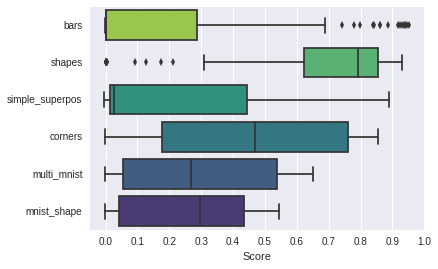

In [21]:
ax = seaborn.boxplot(y=('dataset', 'name'), x='result', data=data, palette='viridis_r')

ax.set_xlim(-0.05, 1)
ax.set_ylabel('')
_ = ax.set_xlabel('Score')
ax.figure.savefig('figures/random_search_summary.pdf', bbox_inches='tight', pad_inches=0)

In [22]:
data_multi_train = get_results(multi_runs)

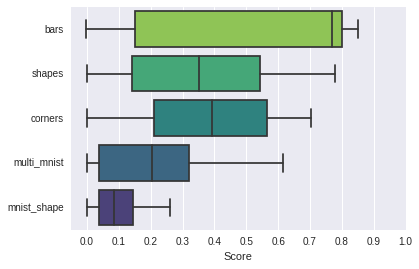

In [23]:
ax = seaborn.boxplot(y=('dataset', 'name'), x='result', data=data_multi_train,  palette='viridis_r')
ax.set_xlim(-0.05, 1)
ax.set_ylabel('')
_ = ax.set_xlabel('Score')
ax.figure.savefig('figures/random_search_multi_summary.pdf', bbox_inches='tight', pad_inches=0)

In [24]:
from bson.code import Code
reducer = Code("""function (obj, prev) {
                      if (obj.result > prev.score) {
                          prev.score = obj.result;
                          prev.dataset = obj.config.dataset.name;
                          prev.network_spec = obj.config.network_spec;
                          prev.learning_rate = obj.config.training.learning_rate;
                          prev.salt_n_pepper = obj.config.dataset.salt_n_pepper;
                      }
                  }""")

## Best results for each dataset

In [25]:
results = runs.group(key=["config.dataset.name"], condition={}, initial={"score": 0}, reduce=reducer)
df = json_normalize(sorted(results, key=lambda x: x['dataset']))
df[df.columns[1:]]

,dataset,learning_rate,network_spec,salt_n_pepper,score
0,bars,0.768015,Fr100,0.0,0.951809
1,corners,0.001920,Fr100,0.0,0.853866
2,mnist_shape,0.031685,Fs250,0.6,0.545559
3,multi_mnist,0.011362,Fr1000,0.6,0.651657
4,shapes,0.083147,Ft500,0.4,0.928792
5,simple_superpos,0.366627,Fr100,0.1,0.890472


## Best MULTI TRAIN results for each dataset 

In [26]:
results = multi_runs.group(key=["config.dataset.name"], condition={}, initial={"score": 0}, reduce=reducer)
df = json_normalize(sorted(results, key=lambda x: x['dataset']))
df[df.columns[1:]]

,dataset,learning_rate,network_spec,salt_n_pepper,score
0,bars,0.012192,Fs100,0.8,0.851777
1,corners,0.026035,Fr100,0.7,0.704285
2,mnist_shape,0.033200,Fr1000,0.6,0.259646
3,multi_mnist,0.001786,Fs250,0.9,0.614277
4,shapes,0.049402,Fs100,0.9,0.776656
